<a href="https://colab.research.google.com/github/Weverton-Vitor/qualifact-course/blob/main/experiment_77.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

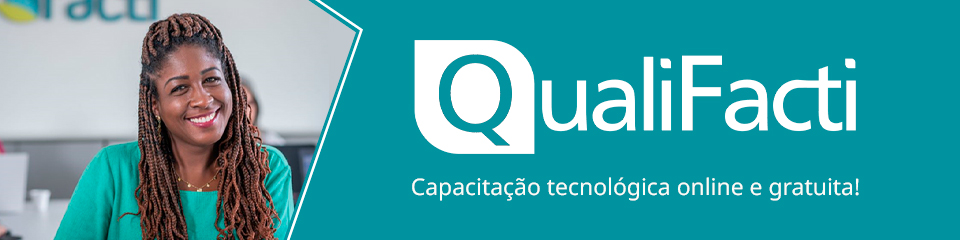

# **Inteligência Artificial aplicada à Visão Computacional**

**Capítulo 9: Visão Computacional aplicada ao reconhecimento e sintetização de voz**



<p align="justify">

Todos os direitos reservados à Facti, 2024
<p>

[www.qualifacti.com.br](https://)

---

<p align="justify">
É importante esclarecer que estas atividades não compõem a avaliação e não haverá correção formal por parte dos instrutores; o objetivo é a autoaprendizagem e prática.
<p>

---

# **ETAPA CONCEITUALIZAR**

---

# **Recado importante**


Olá,
<p align="justify">
Como parte do capítulo de <b>reconhecimento e sintetização de voz</b>, gostaríamos de ressaltar a importância de realizar as atividades de implementação fornecidas. Estas atividades são cuidadosamente desenhadas para reforçar o conteúdo apresentado.
Lembre-se, a implementação é uma habilidade que se aprimora com a prática. Ao aplicar os conceitos aprendidos, especialmente por meio da escrita e execução de códigos, você ganhará uma compreensão mais profunda e prática dos modelos.
Encorajamos todos a dedicar tempo a essas atividades. Ao fazer isso, você não apenas reforçará o que foi ensinado, mas também desenvolverá as habilidades essenciais de resolução de problemas e depuração de código.

Lembrem-se: não basta apenas aprender, é preciso codificar! O caminho para dominar os modelos começa com a experiência prática.

Atenciosamente,

Júlio e Marcelo
<p>

---

# **Atividade de experimentação 77**

Reconhecimento de emoções de fala RAVDESS - SER: Speech Emotion Recognition

**Base de dados: Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)**

 * Contém 7356 arquivos (tamanho total: 24,8 GB);
 * O banco de dados contém 24 atores profissionais (12 mulheres, 12 homens), vocalizando duas declarações lexicalmente combinadas em um sotaque norte-americano neutro;
  * falando as expressões em entonações calmas, felizes, tristes, zangadas, com medo, surpresa e desgosto
  * ou cantando as expressões em entonações calmas, felizes, tristes, raivosas e temerosas
  * assim **totalizando 8 emoções**;




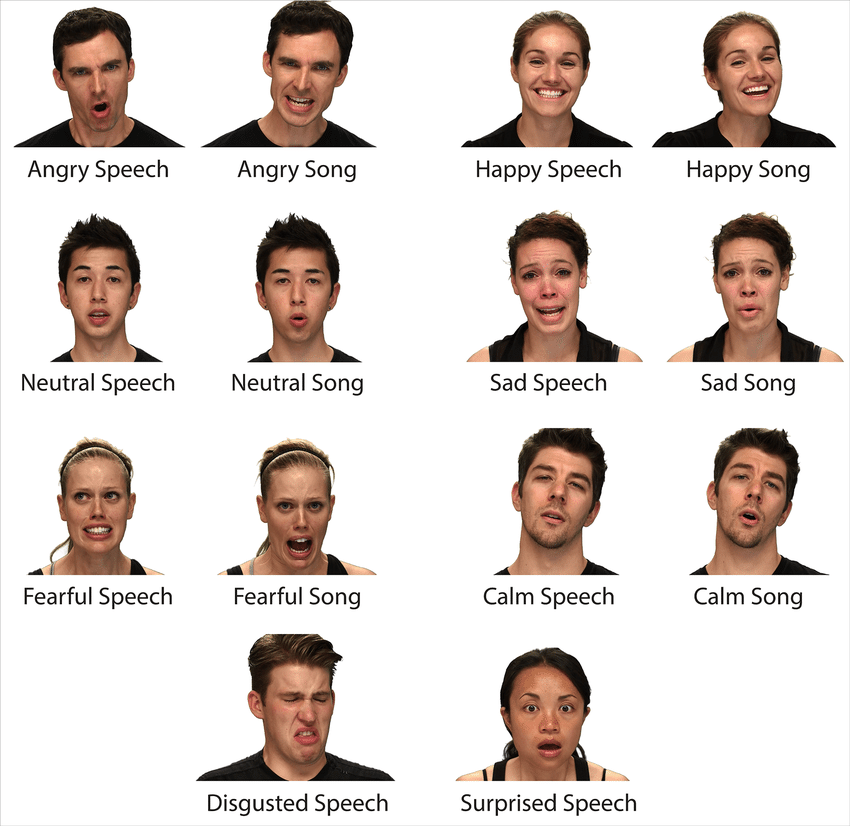

 * Cada expressão é produzida em dois níveis de intensidade emocional (normal, forte), com uma expressão neutra adicional.
 * Toda a base de dados está subdividida em 3 modalidades:
  * somente áudio (16 bits, 48kHz .wav)    
  * áudio-vídeo (720p H.264, AAC 48kHz, .mp4)
  * somente vídeo (sem som).
  
  Nota: Não há arquivos de música para Actor_18.

Mais detalhes sobre a base de dados podem ser vistos na página oficial [RAVDESS](https://smartlaboratory.org/ravdess/).

## Importando as bibliotecas

In [ ]:
import os
import pathlib
from datetime import datetime
import librosa
import librosa.display as ld
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio
from tqdm import tqdm
import tensorflow as tf
print(f'[INFO] tensorflow: {tf.__version__}')
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling1D)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()

[INFO] tensorflow: 2.15.0


## Análise exploratória de dados (EDA)

**Baixando e carregando os datasets: SPEECH/SONG**

Neste projeto serão usados somente os arquivos de áudio contendo as expressões faladas(speech) e cantadas(song) devido a limitação de espaço disponível no Google Drive.

* arquivos de fala (Audio_Speech_Actors) contém 1440 arquivos;
* arquivos de música (Audio_Song_Actors) contém 1012 arquivos.

In [ ]:
# Código para baixar e extrair o dataset de áudio
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip -O Audio_Speech_Actors_01-24.zip
!unzip Audio_Speech_Actors_01-24.zip -d '/content/Audio_Speech_Actors'
!rm Audio_Speech_Actors_01-24.zip

--2024-01-25 04:10:55--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1188976/files/Audio_Speech_Actors_01-24.zip [following]
--2024-01-25 04:10:55--  https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip’

Audio_Speech_Actors 100%[===================>] 198.81M  15.0MB/s    in 1m 51s  

2024-01-25 04:12:47 (1.80 MB/s) - ‘Audio_Speech_Actors_01-24.zip’ saved [208468073/208468073]

Archive:  Audio_Speech_Actors_01-24.zip
   creating: /content/Audio_Speech_Actors/Actor_01/
  inflating: /content/Audio_Speech_Actors/Actor_01/0

## Identificadores de nome de arquivo

Cada um dos 7356 arquivos RAVDESS possui um nome de arquivo exclusivo. O nome do arquivo consiste em um identificador numérico de 7 partes (por exemplo, 03-02-01-01-01-01-01.wav). Esses identificadores definem as características do estímulo.

* Modalidade (01 = AV completo, 02 = apenas vídeo, 03 = apenas áudio).
* Canal vocal (01 = fala, 02 = música).
* Emoção (01 = neutro, 02 = calmo, 03 = feliz, 04 = triste, 05 = zangado, 06 = com medo, 07 = nojo, 08 = surpreso).
* Intensidade emocional (01 = normal, 02 = forte). NOTA: Não há intensidade forte para a emoção 'neutra'.
* Frase (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetição (01 = 1ª repetição, 02 = 2ª repetição).
* Ator (01 a 24. Os atores com números ímpares são homens, os atores com números pares são mulheres).

Exemplo para o arquivo *Audio_Song_Actors/Actor_01/03-02-01-01-01-01-01.wav*:
 * Modalidade 03: Apenas áudio
 * Canal vocal 02: música
 * Emoção 01: neutro
 * Intensidade emocional 01: normal. NOTA: Não há intensidade forte para a emoção 'neutra'.
 * Frase 01: "Kids are talking by the door"
 * Repetição 01: 1ª repetição
 * Ator 01: 1º ator - homem, já que o número de identificação do ator é impar'''

## Criando os datasets

In [ ]:
modalitys = [] # Modalidade (01 = AV completo, 02 = apenas vídeo, 03 = apenas áudio).
voc_channels = [] # Canal vocal (01 = fala, 02 = música).
emotions = [] # Emoção (01 = neutro, 02 = calma, 03 = feliz, 04 = triste, 05 = zangado, 06 = com medo, 07 = nojo, 08 = surpreso).
intensitys = [] # Intensidade emocional (01 = normal, 02 = forte). NOTA: Não há intensidade forte para a emoção 'neutra'.
phrases =[] # Frase (01 = "Crianças conversam perto da porta", 02 = "Cachorros estão sentados na porta").
actors = [] # Ator (01 a 24. Os atores com números ímpares são homens, os atores com números pares são mulheres)

full_path = []

# Função para criar o dataset
def create_dataset(dataset):
  for root, dirs, files in tqdm(os.walk(dataset)):
    for file in files:
      try:
        modal = int(file[1:2])
        vchan = int(file[4:5])
        label = int(file[7:8])
        ints = int(file[10:11])
        phr = int(file[13:14])
        act = int(file[19:20])

        modalitys.append(modal)
        voc_channels.append(vchan)
        emotions.append(label)
        intensitys.append(ints)
        phrases.append(phr)
        actors.append(act)

        full_path.append((root, file))
      except ValueError:
        continue

In [ ]:
# Cria datasets a partir dos arquivos de áudio
create_dataset('/content/Audio_Speech_Actors')

25it [00:00, 1406.31it/s]


In [ ]:
# Mostra o tamanho do dataset de áudio
len(full_path)

1440

In [ ]:
# Mapeia emoções para rótulos textuais
emotions_list = ['neutra', 'calma', 'feliz', 'triste', 'nervosa', 'medo', 'nojo', 'surpreso']
emotion_dict = {em[0] + 1:em[1] for em in enumerate(emotions_list)}
emotion_dict

{1: 'neutra',
 2: 'calma',
 3: 'feliz',
 4: 'triste',
 5: 'nervosa',
 6: 'medo',
 7: 'nojo',
 8: 'surpreso'}

In [ ]:
# Cria DataFrame com as informações extraídas
df = pd.DataFrame([emotions, voc_channels, modalitys, intensitys, actors, phrases, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'phrase', 'path']
df

emotion voc_channel modality intensity actors phrase  \
0          4           1        3         2      8      1   
1          2           1        3         1      8      1   
2          4           1        3         2      8      2   
3          3           1        3         1      8      2   
4          6           1        3         2      8      1   
...      ...         ...      ...       ...    ...    ...   
1435       2           1        3         2      2      2   
1436       1           1        3         1      2      2   
1437       3           1        3         1      2      2   
1438       7           1        3         2      2      1   
1439       6           1        3         1      2      1   

                                                   path  
0     (/content/Audio_Speech_Actors/Actor_08, 03-01-...  
1     (/content/Audio_Speech_Actors/Actor_08, 03-01-...  
2     (/content/Audio_Speech_Actors/Actor_08, 03-01-...  
3     (/content/Audio_Speech_Actors/Actor_08, 03-01-...  
4     (/content/Audio_Speech_Actors/Actor_08, 03-01-...  
...                                                 ...  
1435  (/content/Audio_Speech_Actors/Actor_12, 03-01-...  
1436  (/content/Audio_Speech_Actors/Actor_12, 03-01-...  
1437  (/content/Audio_Speech_Actors/Actor_12, 03-01-...  
1438  (/content/Audio_Speech_Actors/Actor_12, 03-01-...  
1439  (/content/Audio_Speech_Actors/Actor_12, 03-01-...  

[1440 rows x 7 columns]

In [ ]:
# Mapeia valores numéricos para rótulos de texto no DataFrame
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'fala', 2: 'musica'})
df['modality'] = df['modality'].map({1: 'AV completo', 2: 'apenas video', 3: 'apenas audio'})
df['intensity'] = df['intensity'].map({1: 'normal', 2: 'forte'})
df['actors'] = df['actors'].apply({lambda x: 'feminino' if x % 2 == 0 else 'masculino'})
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2: 'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])
df

emotion voc_channel      modality intensity    actors  \
0     triste        fala  apenas audio     forte  feminino   
1      calma        fala  apenas audio    normal  feminino   
2     triste        fala  apenas audio     forte  feminino   
3      feliz        fala  apenas audio    normal  feminino   
4       medo        fala  apenas audio     forte  feminino   
...      ...         ...           ...       ...       ...   
1435   calma        fala  apenas audio     forte  feminino   
1436  neutra        fala  apenas audio    normal  feminino   
1437   feliz        fala  apenas audio    normal  feminino   
1438    nojo        fala  apenas audio     forte  feminino   
1439    medo        fala  apenas audio    normal  feminino   

                            phrase  \
0     Kids are talking by the door   
1     Kids are talking by the door   
2     Dogs are sitting by the door   
3     Dogs are sitting by the door   
4     Kids are talking by the door   
...                            ...   
1435  Dogs are sitting by the door   
1436  Dogs are sitting by the door   
1437  Dogs are sitting by the door   
1438  Kids are talking by the door   
1439  Kids are talking by the door   

                                                   path  
0     /content/Audio_Speech_Actors/Actor_08/03-01-04...  
1     /content/Audio_Speech_Actors/Actor_08/03-01-02...  
2     /content/Audio_Speech_Actors/Actor_08/03-01-04...  
3     /content/Audio_Speech_Actors/Actor_08/03-01-03...  
4     /content/Audio_Speech_Actors/Actor_08/03-01-06...  
...                                                 ...  
1435  /content/Audio_Speech_Actors/Actor_12/03-01-02...  
1436  /content/Audio_Speech_Actors/Actor_12/03-01-01...  
1437  /content/Audio_Speech_Actors/Actor_12/03-01-03...  
1438  /content/Audio_Speech_Actors/Actor_12/03-01-07...  
1439  /content/Audio_Speech_Actors/Actor_12/03-01-06...  

[1440 rows x 7 columns]

## Visualizando a distribuição

In [ ]:
# Visualiza a distribuição das emoções
df.describe()

emotion voc_channel      modality intensity    actors  \
count     1440        1440          1440      1440      1440   
unique       8           1             1         2         2   
top     triste        fala  apenas audio    normal  feminino   
freq       192        1440          1440       768       720   

                              phrase  \
count                           1440   
unique                             2   
top     Kids are talking by the door   
freq                             720   

                                                     path  
count                                                1440  
unique                                               1440  
top     /content/Audio_Speech_Actors/Actor_08/03-01-04...  
freq                                                    1

In [ ]:
# Cria um arquivo csv com os dados da distribuição
df.to_csv(os.path.join('/content', 'Audio_Actors_metadata.csv'), index = False)

In [ ]:
# Visualiza a quantidade de áudios para cada emoção
df.emotion.value_counts()

triste      192
calma       192
feliz       192
medo        192
nojo        192
surpreso    192
nervosa     192
neutra       96
Name: emotion, dtype: int64

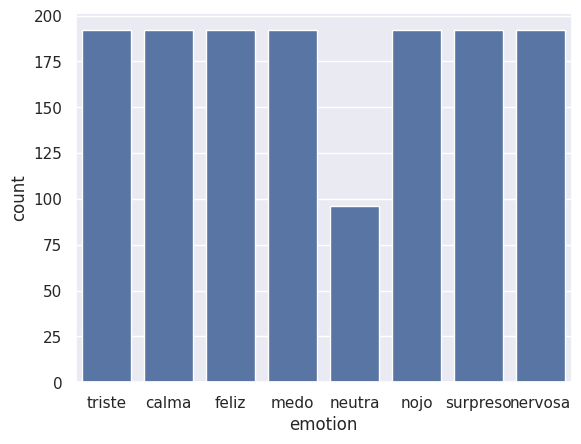

In [ ]:
# Visualização gráfica
sns.countplot(df, x='emotion');

## Visualizando os dados de áudio

**Waveforms**

Canais: (166566,)
Número total de amostras: 166566
Arquivo:  /content/Audio_Speech_Actors/Actor_14/03-01-03-01-02-02-14.wav
Taxa de amostragem: 48000
Duração:  3.470125


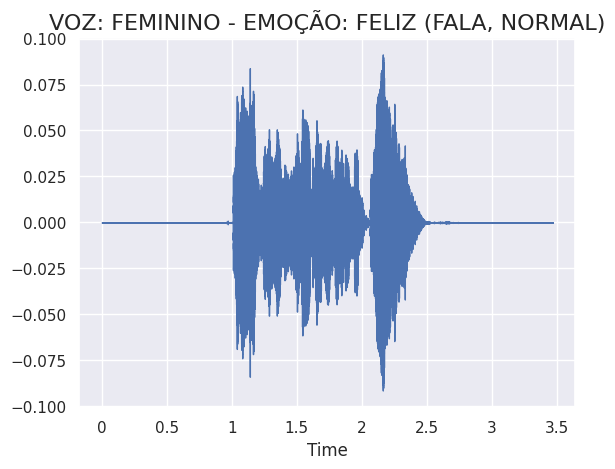

In [ ]:
# Visualiza formas de onda e espectrogramas dos dados de áudio
n_files = df.shape[0]
rnd = np.random.randint(0, n_files)

fname = df.path[rnd]
data, sample_rate = librosa.load(fname, sr=None)

print('Canais:', data.shape)
print('Número total de amostras:', data.shape[0])
print('Arquivo: ', fname)
print('Taxa de amostragem:', sample_rate)
print('Duração: ', len(data) / sample_rate)

info = df.iloc[rnd].values
title_txt = f'voz: {info[4]} - emoção: {info[0]} ({info[1]}, {info[3]})'
plt.title(title_txt.upper(), size=16)
ld.waveshow(data, sr=sample_rate)
Audio(data = data, rate = sample_rate)

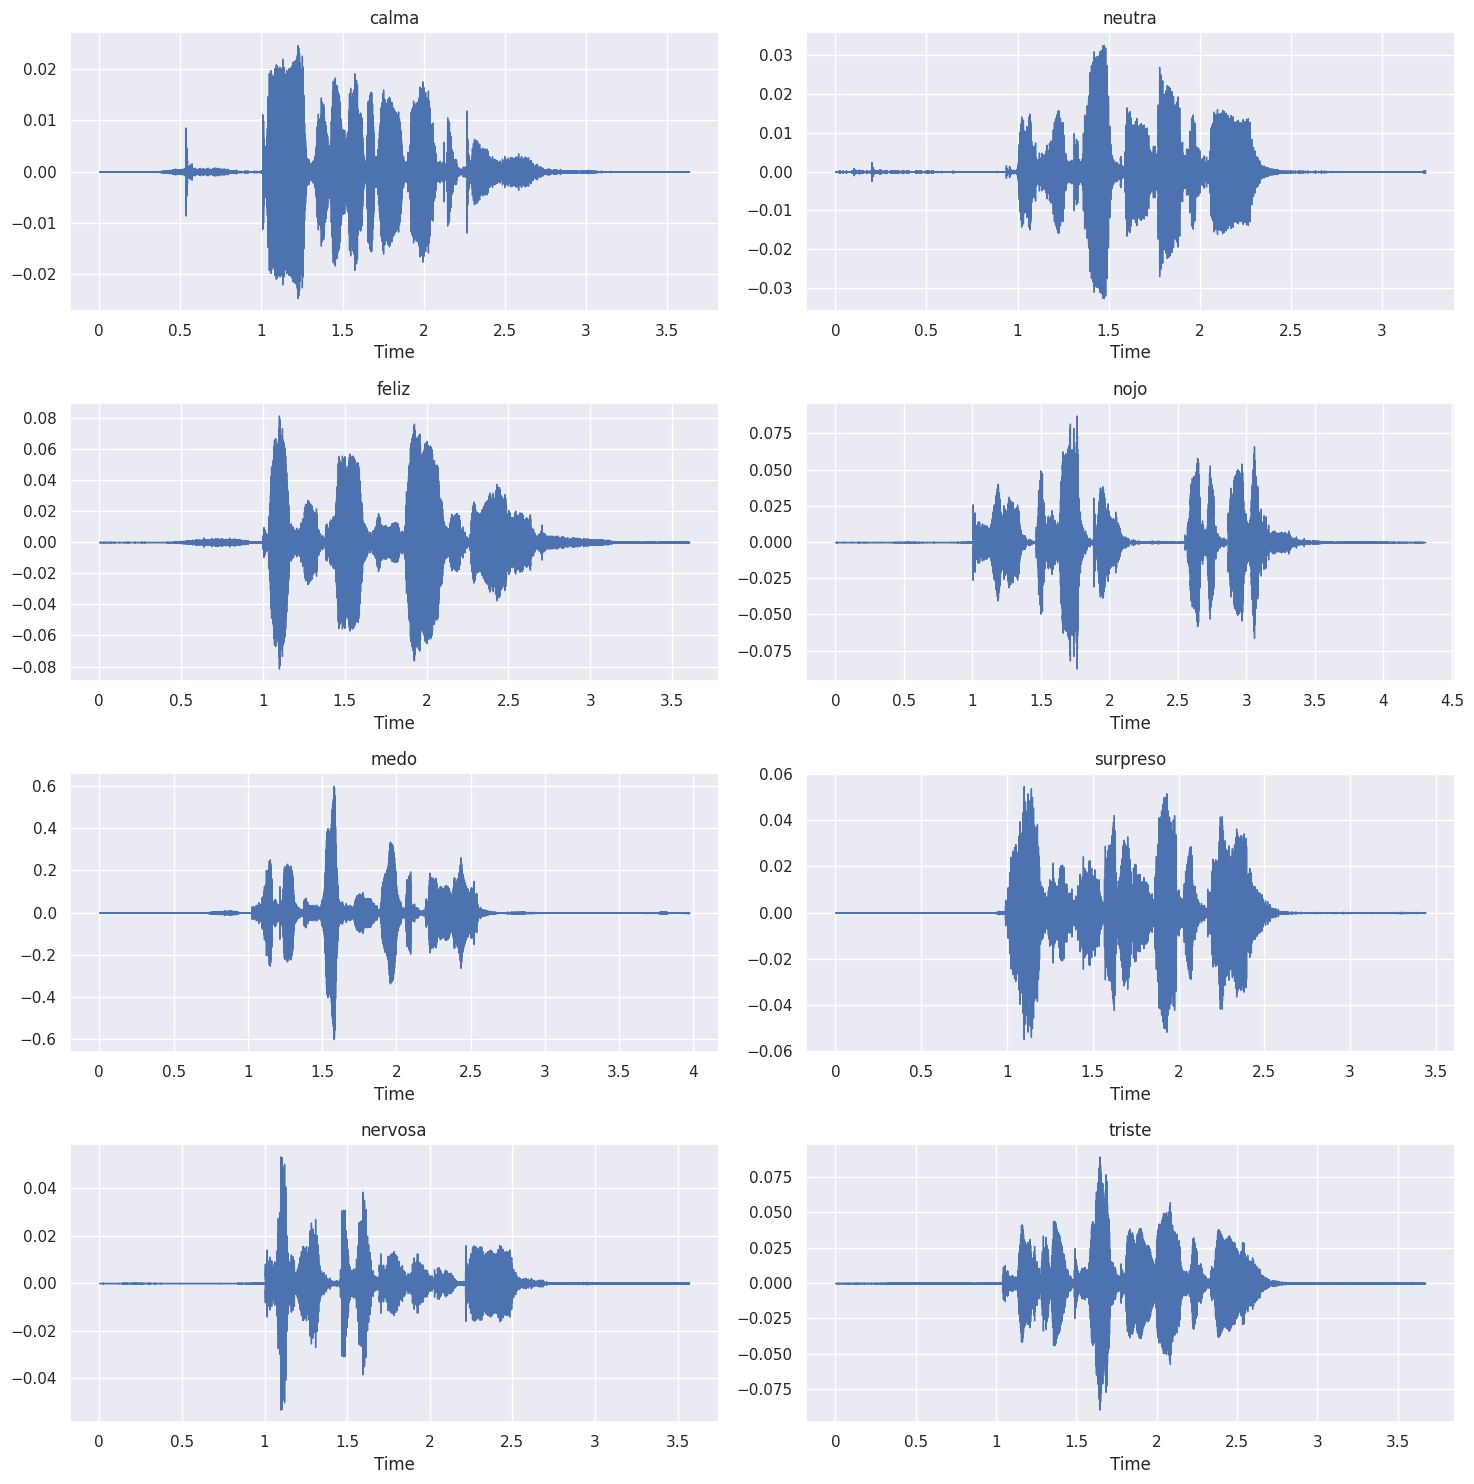

In [ ]:
# Escolha aleatória de visualizações de formas de onda e espectrogramas de cada emoção
random_samples = df.groupby('emotion').sample(1)
audio_samples, labels = random_samples['path'].tolist(), random_samples['emotion'].tolist()

rows=4
cols=2
fig, axs = plt.subplots(rows, cols, figsize=(15,15))
index = 0
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        librosa.display.waveshow(data, sr=sample_rate, ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()

### Espectrogramas de STFT

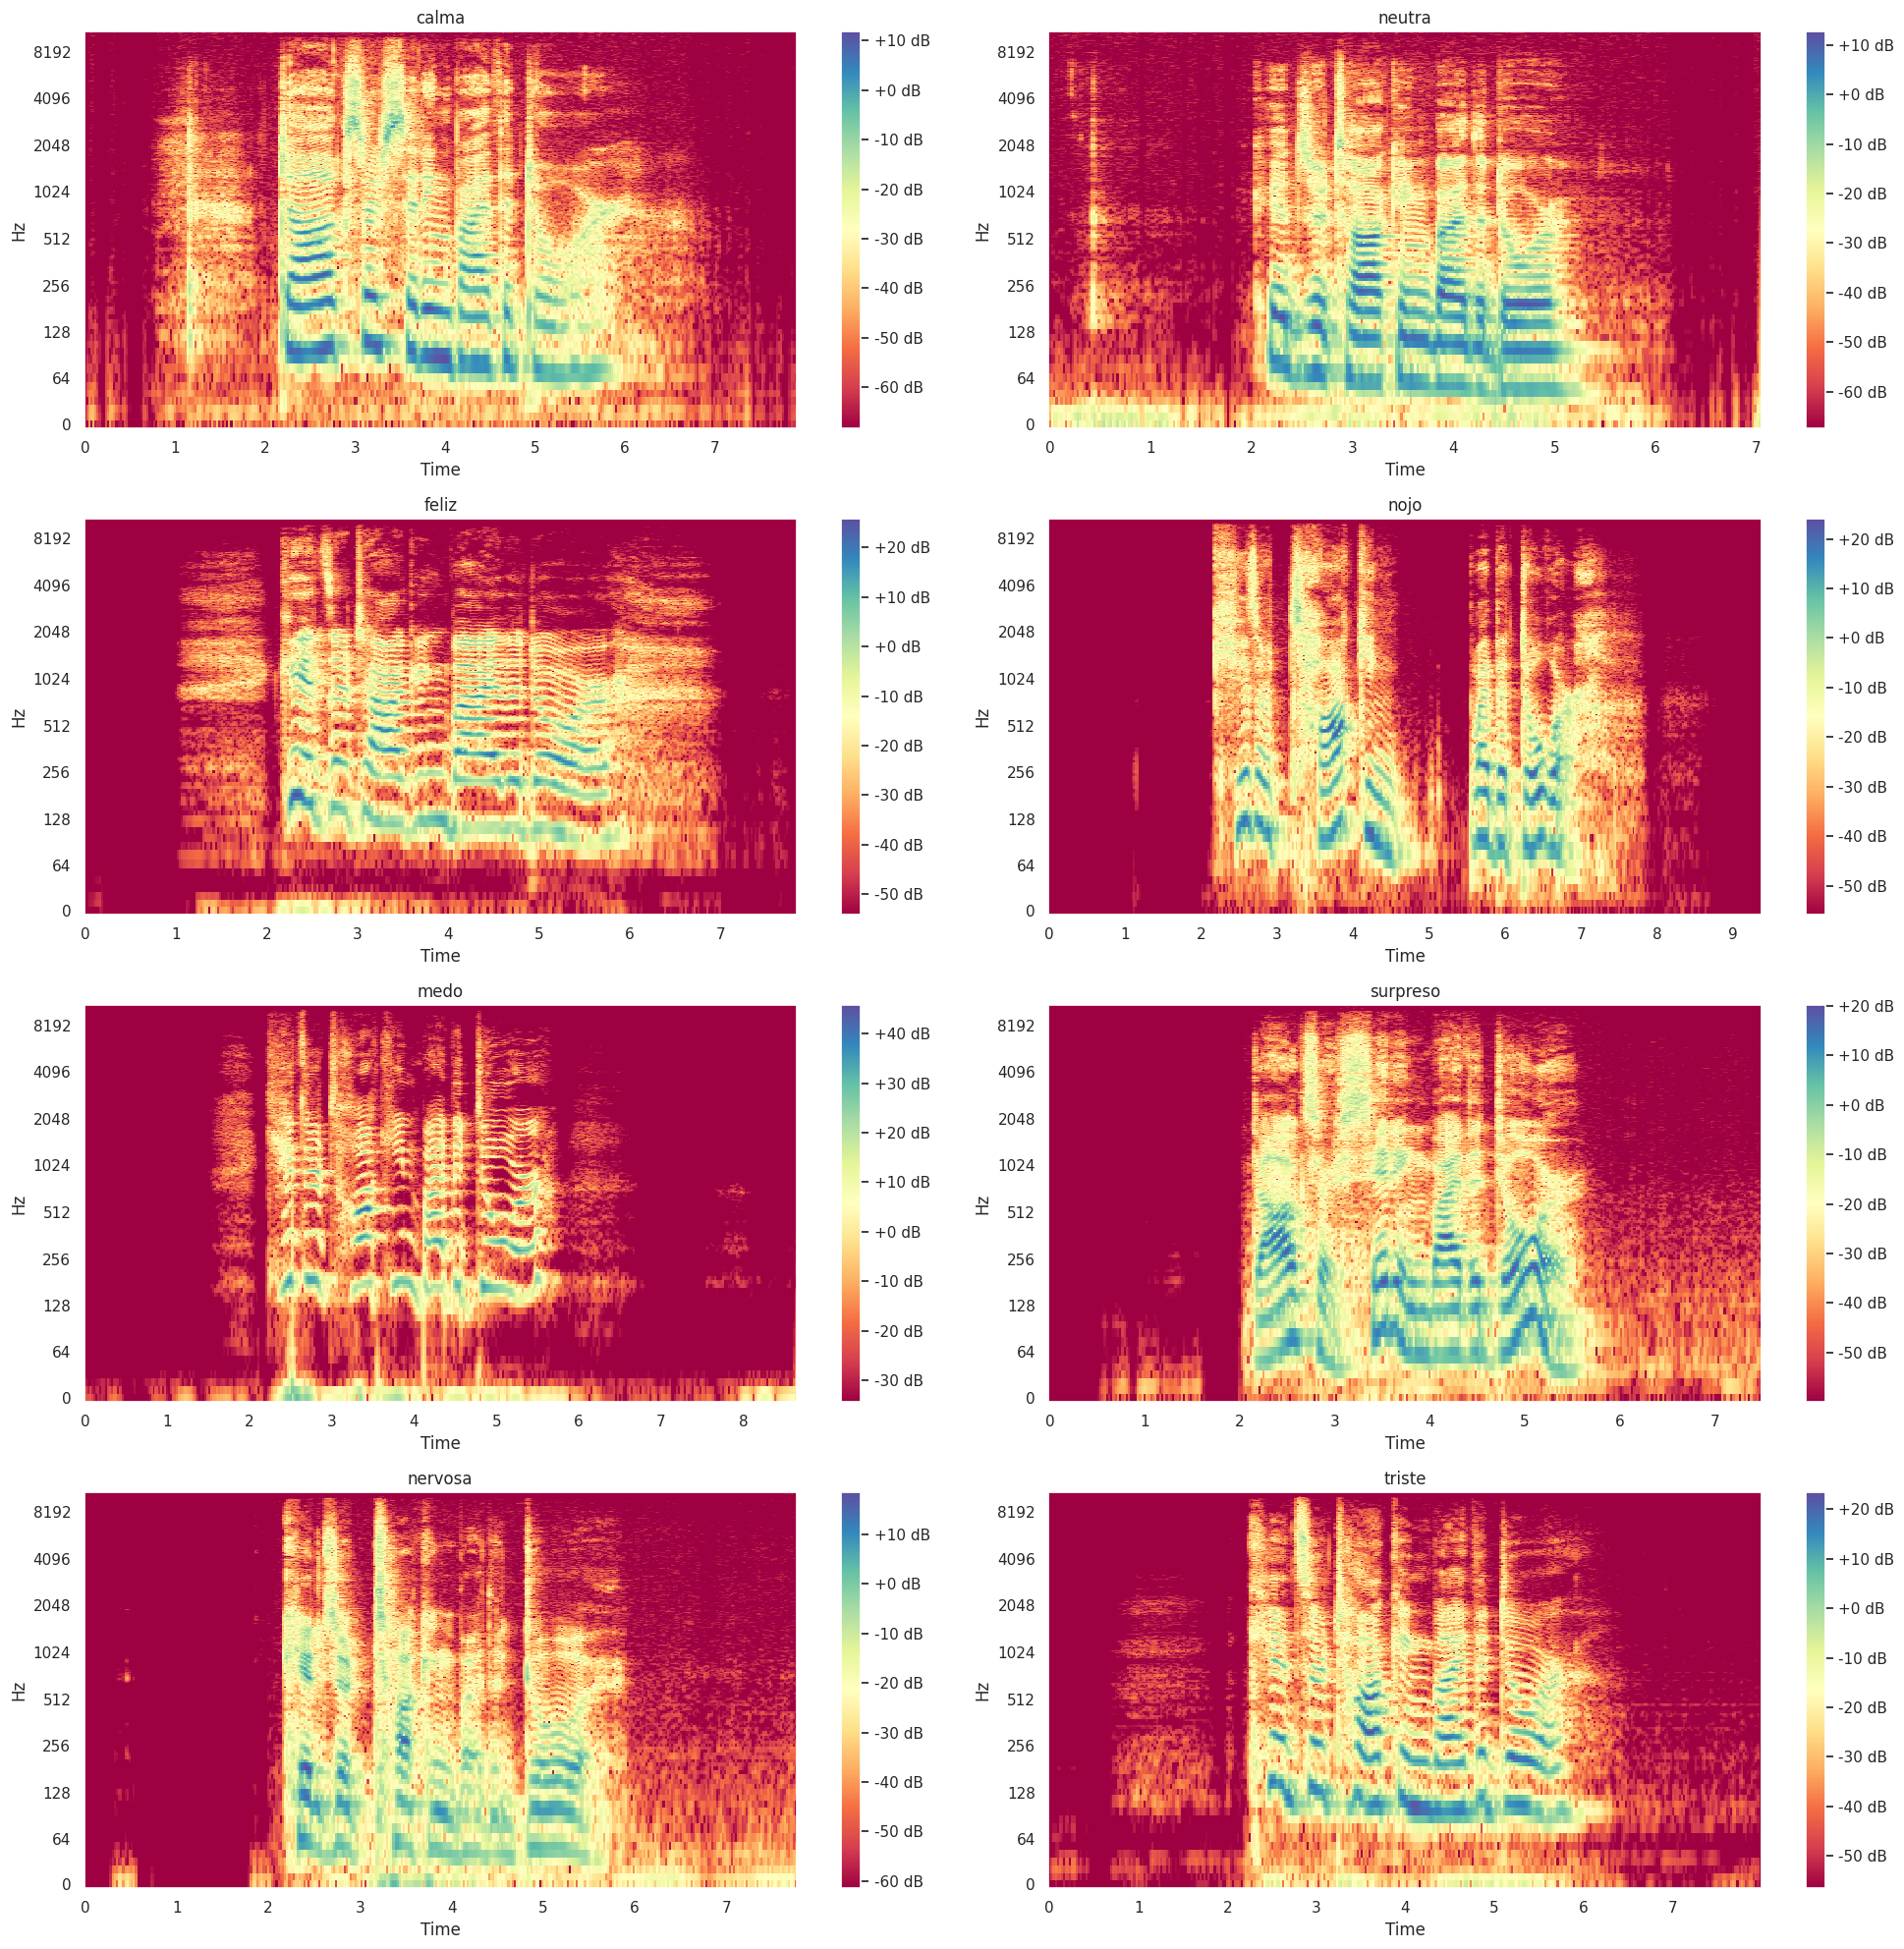

In [ ]:
# Cria o espectrograma para cada uma das emoções
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
index = 0
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        stft = librosa.stft(y = data)
        stft_db = librosa.amplitude_to_db(np.abs(stft))
        img = librosa.display.specshow(stft_db, x_axis="time", y_axis='log', ax=axs[row][col], cmap = 'Spectral')
        axs[row][col].set_title('{}'.format(labels[index]))
        fig.colorbar(img, ax=axs[row][col], format='%+2.f dB')
        index += 1
fig.tight_layout()

### Espectrogramas de MFCCs

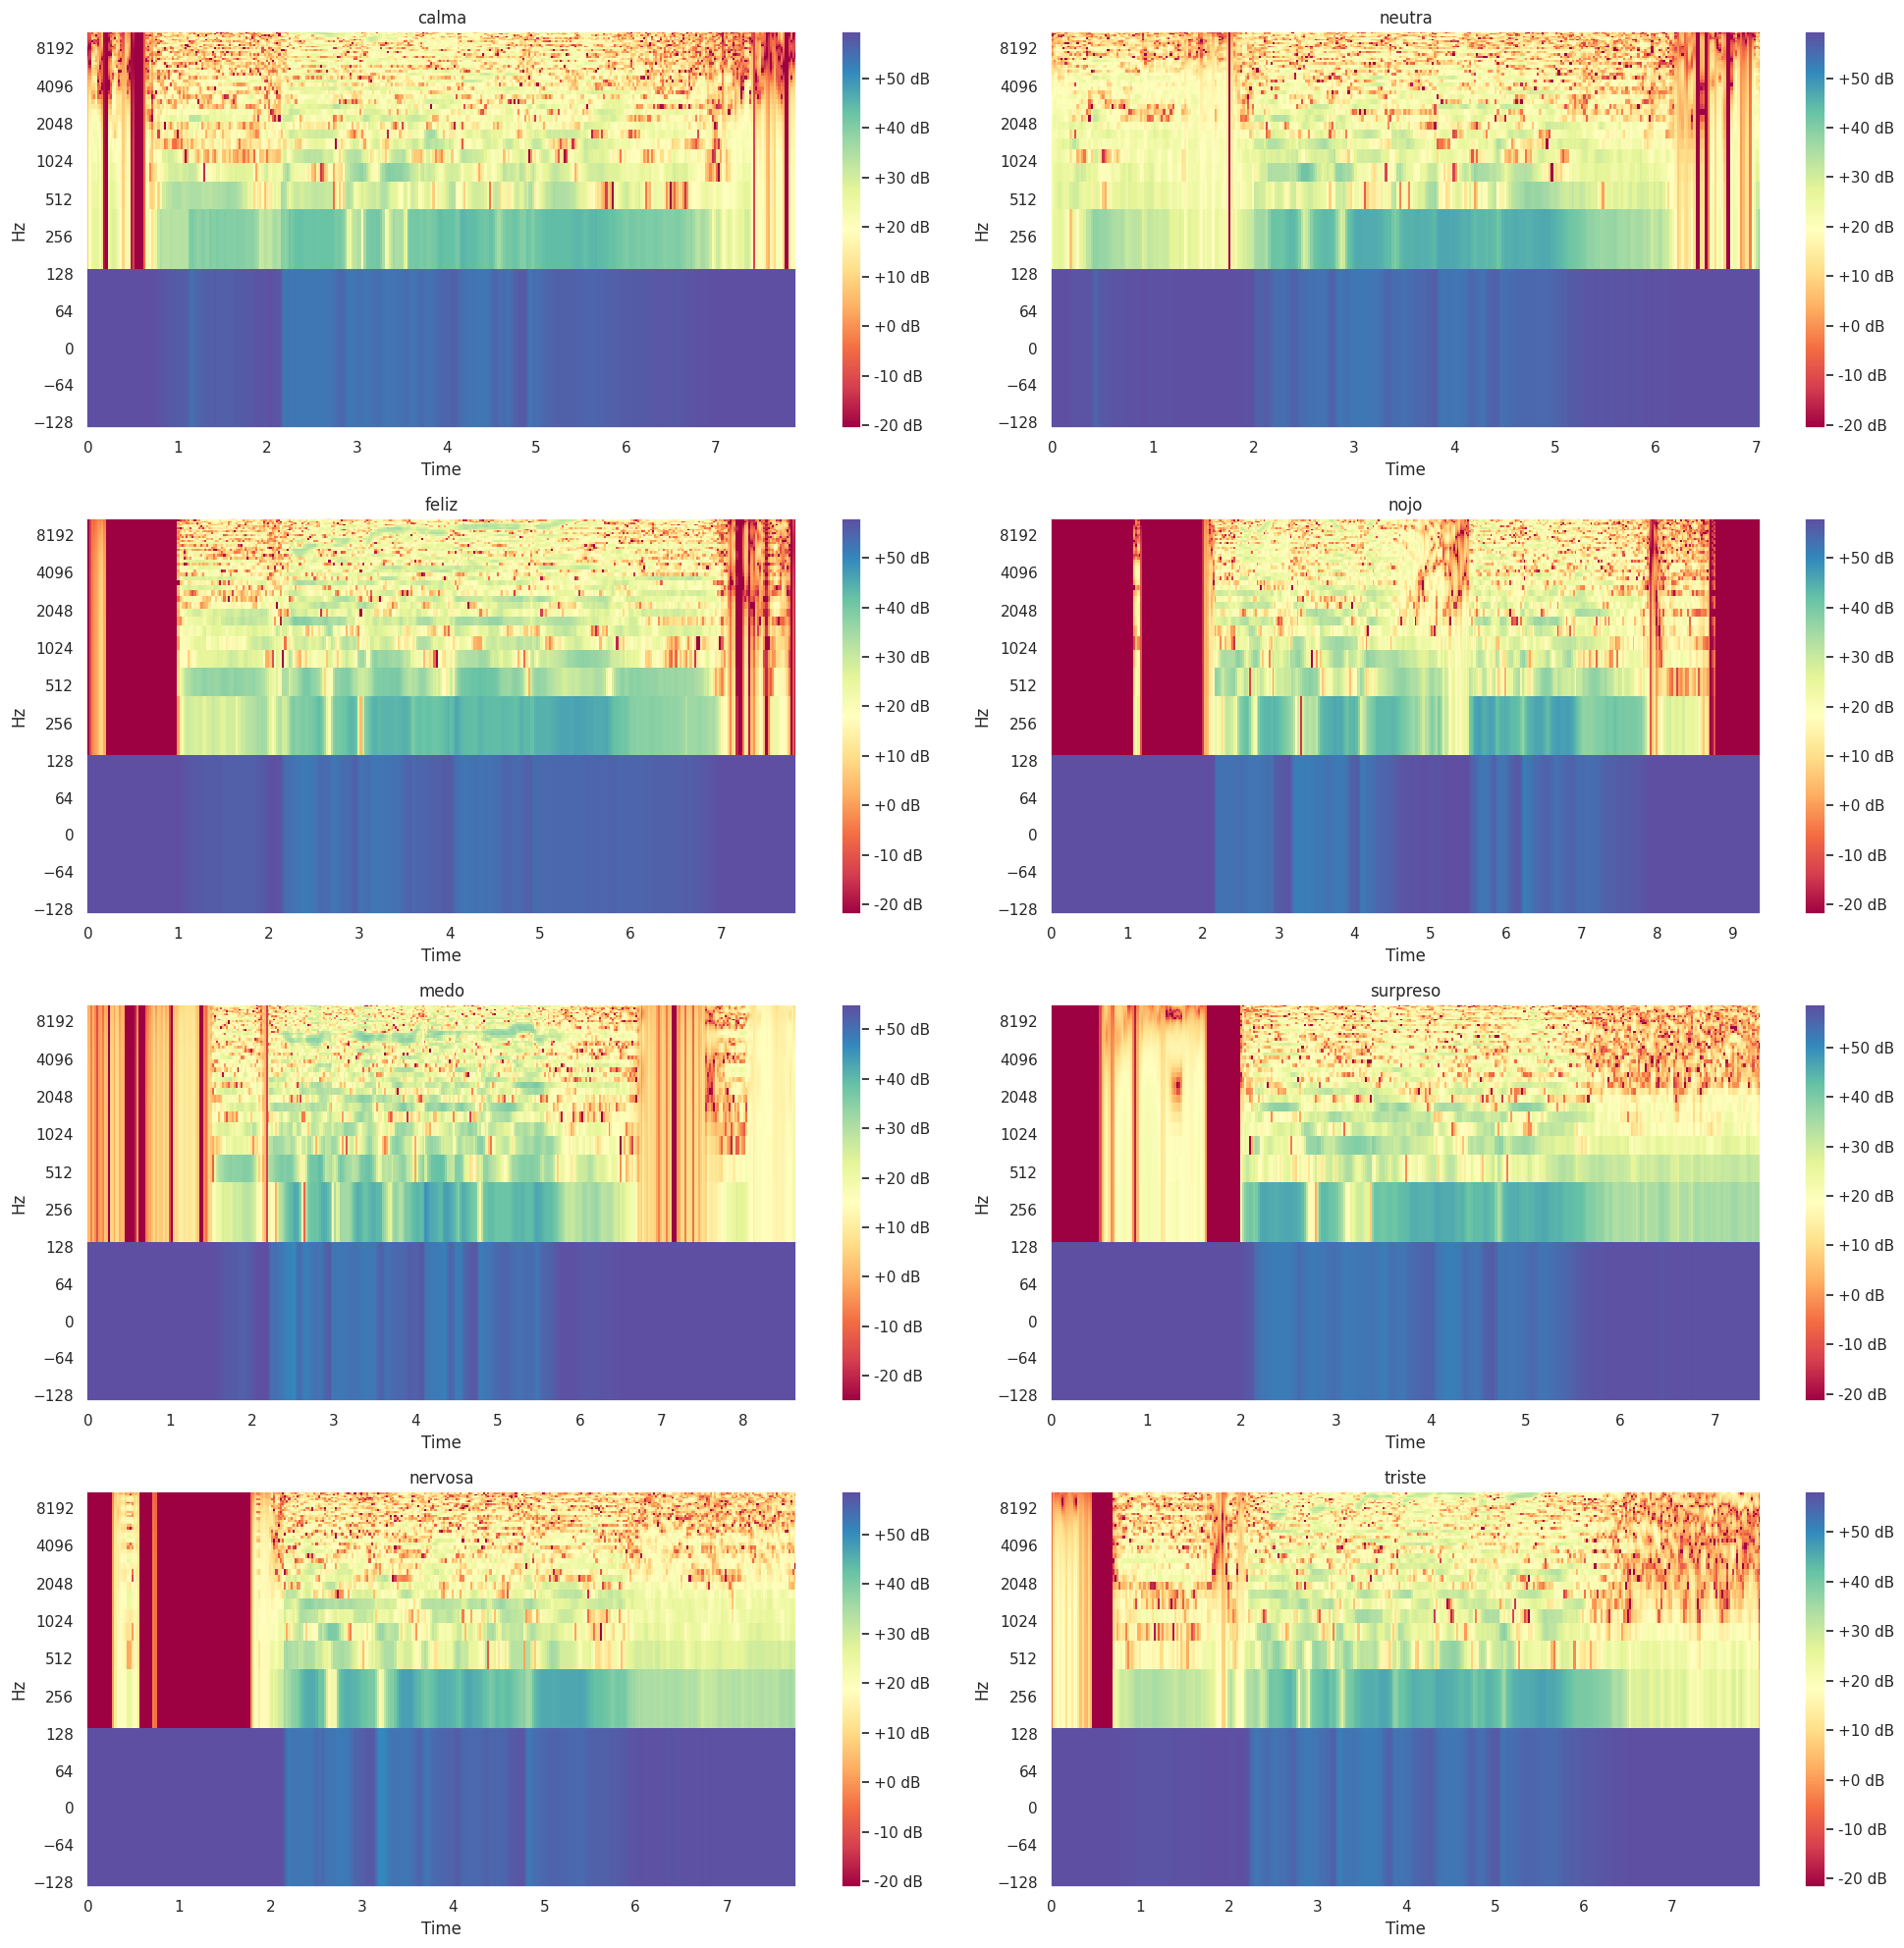

In [ ]:
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
index = 0
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        mfccs = librosa.feature.mfcc(y = data, sr=sample_rate, n_mfcc=40)
        mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))
        img = librosa.display.specshow(mfccs_db, x_axis="time", y_axis='log', ax=axs[row][col], cmap = 'Spectral')
        axs[row][col].set_title('{}'.format(labels[index]))
        fig.colorbar(img, ax=axs[row][col], format='%+2.f dB')
        index += 1

fig.tight_layout()

## Pré-processamento


### Extraindo recursos/características MFCC's de cada arquivo de áudio do dataset


In [ ]:
# Extrai características MFCC
def features_extractor(file_name):
    data, sample_rate = librosa.load(file_name, sr = None, res_type = 'kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)
    return mfccs_scaled_features

extracted_features=[]
for path in tqdm(df.path.values):
  data = features_extractor(path)
  extracted_features.append([data])

100%|██████████| 1440/1440 [00:57<00:00, 25.13it/s]


## Convertendo os recursos extraídos para visualização com Pandas

In [ ]:
# Converte os recursos extraídos em DataFrame para visualização
extracted_features_df = pd.DataFrame(extracted_features, columns = ['feature'])

## Dividindo entre atributos classe(class) e atributos previsores(features)

In [ ]:
# Divide os dados em atributos de classe e atributos previsores
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(df.emotion.tolist())

In [ ]:
# Cria um objeto para converter rótulos categóricos em valores numéricos
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [ ]:
# Classes identificadas
labelencoder.classes_

array(['calma', 'feliz', 'medo', 'nervosa', 'neutra', 'nojo', 'surpreso',
       'triste'], dtype='<U8')

In [ ]:
# Divide os dados em conjuntos de treinamento e teste.
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
# Adiciona uma nova dimensão aos dados de treinamento e teste.
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

In [ ]:
# Quantidade de classes de emoções
num_labels = y.shape[1]
num_labels

8

## Criando o modelo

**Criação da estrutura da rede neural**

Os espectrogramas extraídos dos arquivos de áudio são como imagens 2D, então podemos usar técnicas de classificação de imagens neles, especificamente Redes Neurais Convolucionais (CNN)!

A arquitetura desta rede neural foi definida com base em alguns testes realizados para obter o resultado esperado. A estrutura pode ser ajustada livremente e comparada aos resultados desta estrutura.

 * Parâmetros:
  * `Sequential`, é a classe para criar a rede neural, pois uma rede neural nada mais é que uma sequência de camadas (camada e entrada, camadas ocultas, camada de saída);  
  * `kernel_size`, o tamanho do kernel (matriz) de convolução;
  * `activation`, função de ativação;
  * `input_shape`, na primeira camada este é o tamanho dos dados de entrada
  * Camada `MaxPooling1D`, que vai fazer a extração das características principais;
  * Camada `Conv1d`, uma rede neural convolucional que realiza a convolução ao longo de apenas uma dimensão;
  * Camada `Flatten`, para transformar de matriz em vetor;
  * Camada `Dense`, quando um neurônio de uma camada está ligado a todas os outros neurônios das outras camadas;
  * `Dropout`, técnica de regularização para diminuir o overfitting;
  * `padding='same'`, indica que adicionamos uma nova coluna composta por somente 0 (zeros) e utilizamos toda a imagem;

In [ ]:
# Define o formato de entrada para o modelo de rede neural.
input_shape=(X_train.shape[1],1)

In [ ]:
# Cria o modelo de rede neural
model=Sequential()

model.add(Conv1D(64, kernel_size=(5), activation='relu',input_shape=(X_train.shape[1],1)))

model.add(Conv1D(128, kernel_size=(5),activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=(5)))

model.add(Conv1D(256, kernel_size=(5),activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 64)            384       
                                                                 
 conv1d_1 (Conv1D)           (None, 36, 128)           41088     
                                                                 
 max_pooling1d (MaxPooling1  (None, 7, 128)            0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 256)            164096    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 256)            0         
 g1D)                                                            
                                                                 
 dropout (Dropout)           (None, 1, 256)            0

## Treinando o modelo
 * `num_epochs`, número de épocas de treinamento
 * `num_batch_size`, isto indica que vamos enviar de 32 em 32 recursos de áudio (32, 64, 96, 128,...8732)

ModelCheckpoint, para salvar o modelo enquanto faz o treinamento
 * `filepath`, caminho onde será salvo o modelo. Para isto temos uma pasta no Drive chamada *saved_models*
 * `verbose`, mostrar mensagens enquanto a rede neural é treinada
 * `save_best_only = True`, para salvar o modelo somente quando houver uma melhora no resultado

Variáveis para efetuar a contagem do tempo de treinamento:
 * `start`, pegando o horário atual de início do treinamento;
 * `duration`, ao final do treinamento, subtrair a hora atual com hora de início do treinamento.

`model_history` para armazenar o histórico de treinamento:
 * `model.fit` para fazer o ajuste do pesos ao longo do treinamento
  * `X_train`, `Y_train`, dados de treinamento
  * `batch_size = num_batch_size` que definimos acima
  * `epochs = num_epochs` que também definimos acima
  * `validation_data=(X_test, Y_test)`, dados de teste para monitorarmos como está o percentual de acerto da rede neural a cada época
  * `callbacks=[checkpointer]`, checkpointer definido anteriormente
  * `verbose = 1`, para mostrar as mensagens

In [ ]:
# Montagem do Google Drive para acessar arquivos armazenados
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Realize o dowload da pasta Material_complementar_reconhecimento_voz.zip do Google Sala de Aula e transfira-a para o seu Google Drive
# Localize o caminho da pasta no menu Arquivos, no menu lateral esquerdo
import zipfile
path = "/content/gdrive/MyDrive/Material_complementar_reconhecimento_voz.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")

In [ ]:
# Treina o modelo conforme o modelo já treinado disponível na pasta modelos do Material_complementar_reconhecimento_voz.zip
num_epochs = 50
num_batch_size = 64

checkpointer = ModelCheckpoint(filepath='/content/modelos/speech_emotion_recognition.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()
model_history = model.fit(X_train, Y_train, batch_size=num_batch_size, epochs=num_epochs,
                          validation_data=(X_test, Y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("[INFO] treinamento concluído em: ", duration)

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 4.5777 - accuracy: 0.1380
Epoch 1: val_loss improved from inf to 2.12804, saving model to /content/modelos/speech_emotion_recognition.hdf5
18/18 [==============================] - 4s 79ms/step - loss: 4.5777 - accuracy: 0.1380 - val_loss: 2.1280 - val_accuracy: 0.1181
Epoch 2/50
 1/18 [>.............................] - ETA: 0s - loss: 2.2075 - accuracy: 0.1562

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/18 [===========================>..] - ETA: 0s - loss: 2.1237 - accuracy: 0.1838
Epoch 2: val_loss improved from 2.12804 to 2.01738, saving model to /content/modelos/speech_emotion_recognition.hdf5
18/18 [==============================] - 1s 51ms/step - loss: 2.1186 - accuracy: 0.1840 - val_loss: 2.0174 - val_accuracy: 0.2049
Epoch 3/50
17/18 [===========================>..] - ETA: 0s - loss: 2.0455 - accuracy: 0.1857
Epoch 3: val_loss improved from 2.01738 to 1.98556, saving model to /content/modelos/speech_emotion_recognition.hdf5
18/18 [==============================] - 1s 48ms/step - loss: 2.0460 - accuracy: 0.1840 - val_loss: 1.9856 - val_accuracy: 0.2326
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 1.9867 - accuracy: 0.2361
Epoch 4: val_loss improved from 1.98556 to 1.95467, saving model to /content/modelos/speech_emotion_recognition.hdf5
18/18 [==============================] - 1s 59ms/step - loss: 1.9867 - accuracy: 0.2361 - val_loss: 1.9547 - val_accur

## Avaliando o modelo

In [ ]:
# Avalia o desempenho do modelo treinado usando o conjunto de teste.
model.evaluate(X_test,Y_test, verbose=0)

[1.1397508382797241, 0.7048611044883728]

In [ ]:
# Imprime as chaves do dicionário 'history' que contém os registros do histórico de treinamento do modelo.
print(model_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


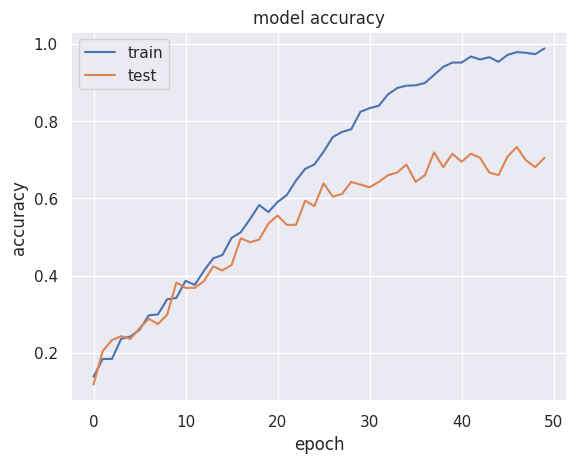

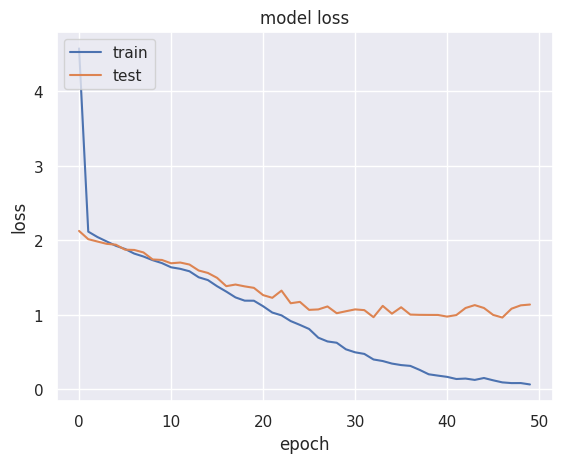

In [ ]:
# Plota o gráfico da precisão (accuracy) e perda (loss) do modelo durante o treinamento e a validação.
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Comparando as classes reais com as classes previstas

In [ ]:
# Compara classes reais com as previstas
predictions = model.predict(X_test)

9/9 [==============================] - 0s 6ms/step


In [ ]:
# Converte as probabilidades das previsões em rótulos de classe. Cada previsão contém um conjunto de probabilidades para cada classe.
predictions = predictions.argmax(axis=1)

In [ ]:
# Converte os índices de previsão em inteiros e os achata em um array unidimensional. Isso é necessário para processar as previsões.
predictions = predictions.astype(int).flatten()
predictions = (labelencoder.inverse_transform((predictions)))
predictions = pd.DataFrame({'Classes Previstas': predictions})
predictions

Classes Previstas
0                medo
1            surpreso
2             nervosa
3              neutra
4                medo
..                ...
283           nervosa
284             feliz
285             calma
286              nojo
287             calma

[288 rows x 1 columns]

In [ ]:
# Converte a matriz de rótulos de teste (Y_test) para obter o índice da classe com a maior probabilidade (classe real) para cada amostra.
actual = Y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (labelencoder.inverse_transform((actual)))
actual = pd.DataFrame({'Classes Reais': actual})
actual

Classes Reais
0            medo
1           feliz
2         nervosa
3           calma
4            medo
..            ...
283       nervosa
284         feliz
285         calma
286          nojo
287         calma

[288 rows x 1 columns]

In [ ]:
# Combina os DataFrames 'actual' e 'predictions' para criar um novo DataFrame chamado 'finaldf'.
finaldf = actual.join(predictions)
finaldf[140:150]

Classes Reais Classes Previstas
140        triste              medo
141         feliz             feliz
142      surpreso            triste
143          nojo              nojo
144        triste              medo
145          nojo            triste
146       nervosa           nervosa
147          medo              nojo
148         calma             calma
149       nervosa           nervosa

### Exibindo a Matriz de confusão

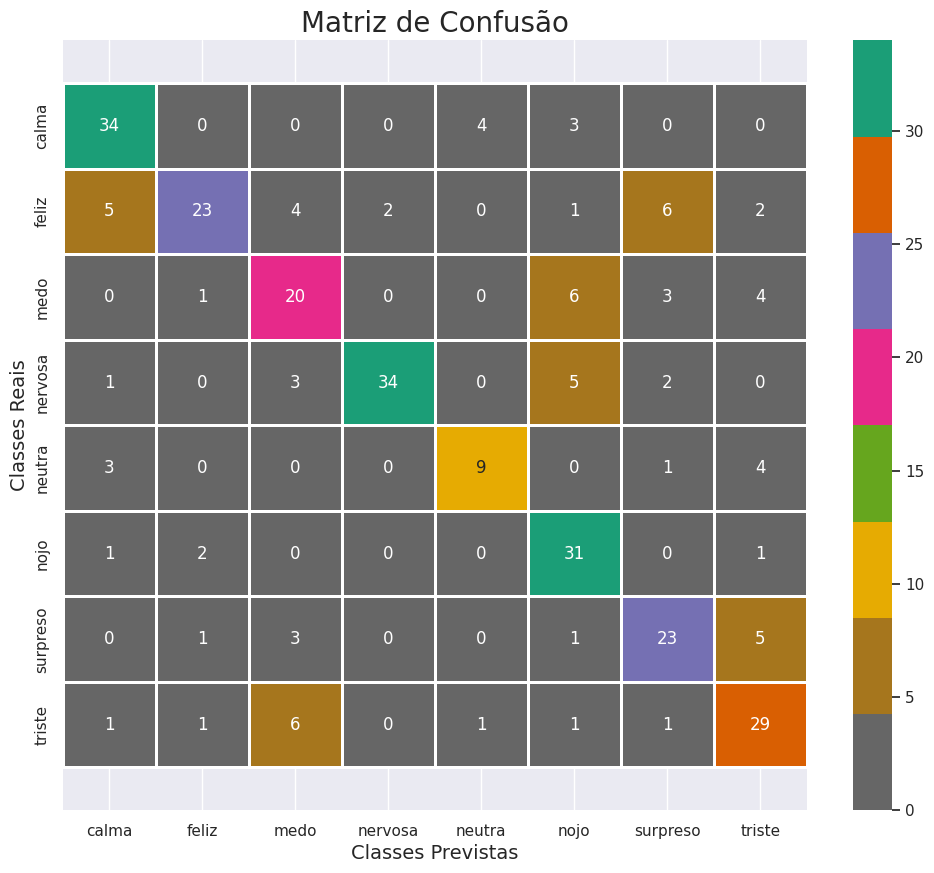

In [ ]:
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in labelencoder.classes_] , columns = [i for i in labelencoder.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Dark2_r', linewidth=1, annot=True, fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Matriz de Confusão', size=20)
plt.xlabel('Classes Previstas', size=14)
plt.ylabel('Classes Reais', size=14)
plt.show()

### Visualizando a taxa e acerto para cada uma das classes

In [ ]:
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

       calma       0.76      0.83      0.79        41
       feliz       0.82      0.53      0.65        43
        medo       0.56      0.59      0.57        34
     nervosa       0.94      0.76      0.84        45
      neutra       0.64      0.53      0.58        17
        nojo       0.65      0.89      0.75        35
    surpreso       0.64      0.70      0.67        33
      triste       0.64      0.72      0.68        40

    accuracy                           0.70       288
   macro avg       0.71      0.69      0.69       288
weighted avg       0.72      0.70      0.70       288



# Testando o modelo em arquivos de áudio

In [ ]:
def getInfo(data, sample_rate):
  print('Canais: ', data.shape)
  print('Número total de amostras: ', data.shape[0])
  print('Taxa de amostragem: ', sample_rate)
  print('Duração: ',  len(data) / sample_rate)

def predictSound(AUDIO, info = False, plot_waveform = False, plot_spectrogram = False):
  audio, sample_rate = librosa.load(AUDIO, sr = None, res_type='kaiser_fast')
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
  mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
  mfccs_scaled_features = mfccs_scaled_features[:,:,np.newaxis]
  predictions = model.predict(mfccs_scaled_features)
  plt.barh(labelencoder.classes_, predictions[0], color=list('rgbkymc'))
  predictions = predictions.argmax(axis=1)
  predictions = predictions.astype(int).flatten()
  predictions = (labelencoder.inverse_transform((predictions)))
  print('Resultado:', predictions)

  if info:
    getInfo(audio, sample_rate)

  if plot_waveform:
    plt.figure(figsize=(14,5))
    plt.title('Emoção: ' + str(predictions[0]).upper(), size=16)
    plt.xlabel("Tempo (segundos) ==>")
    plt.ylabel("Amplitude")
    ld.waveshow(audio, sr=sample_rate)

  if plot_spectrogram:
    plt.figure(figsize=(14,5))
    mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))
    plt.title('Emoção: ' + str(predictions[0]).upper(), size=16)
    ld.specshow(mfccs_db, x_axis="time", y_axis='log', cmap = 'Spectral')
    plt.colorbar(format='%+2.f dB')

In [ ]:
AUDIO = "/content/Audio_Speech_Actors/Actor_02/03-01-01-01-01-01-02.wav" # Teste diferentes áudios
audio, sample_rate = librosa.load(AUDIO, sr = None, res_type='kaiser_fast')
Audio(data = audio, rate = sample_rate)

1/1 [==============================] - 0s 123ms/step
Resultado: ['neutra']
Canais:  (174574,)
Número total de amostras:  174574
Taxa de amostragem:  48000
Duração:  3.6369583333333333


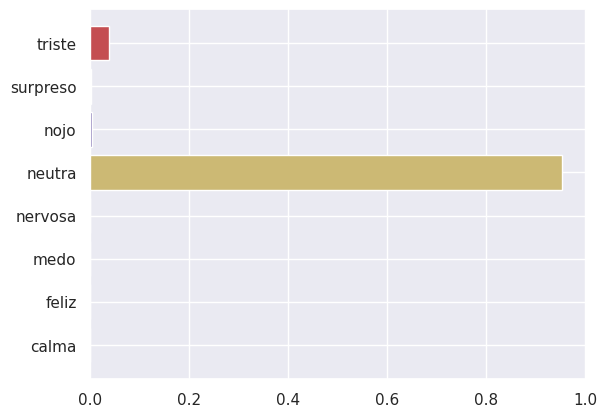

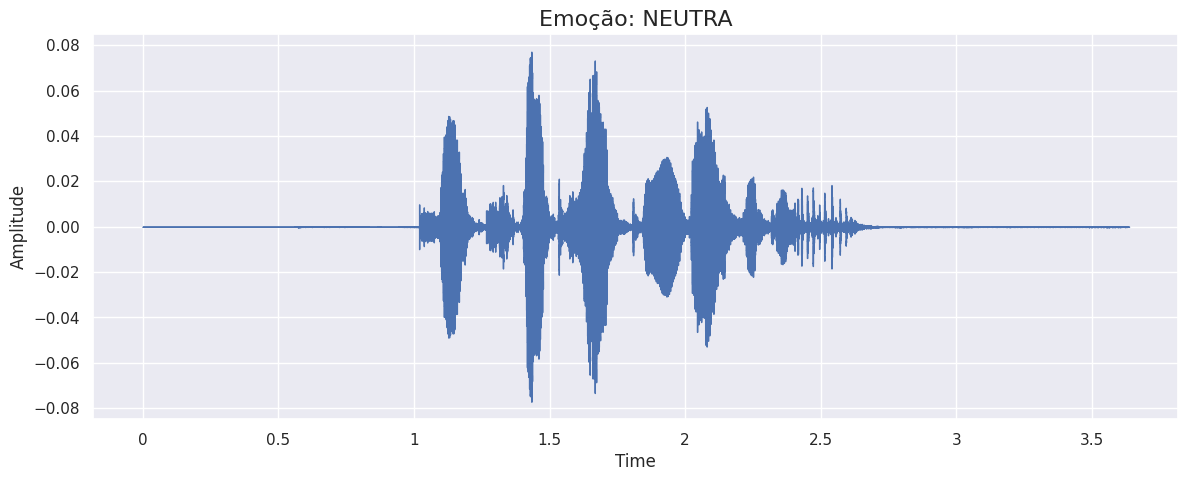

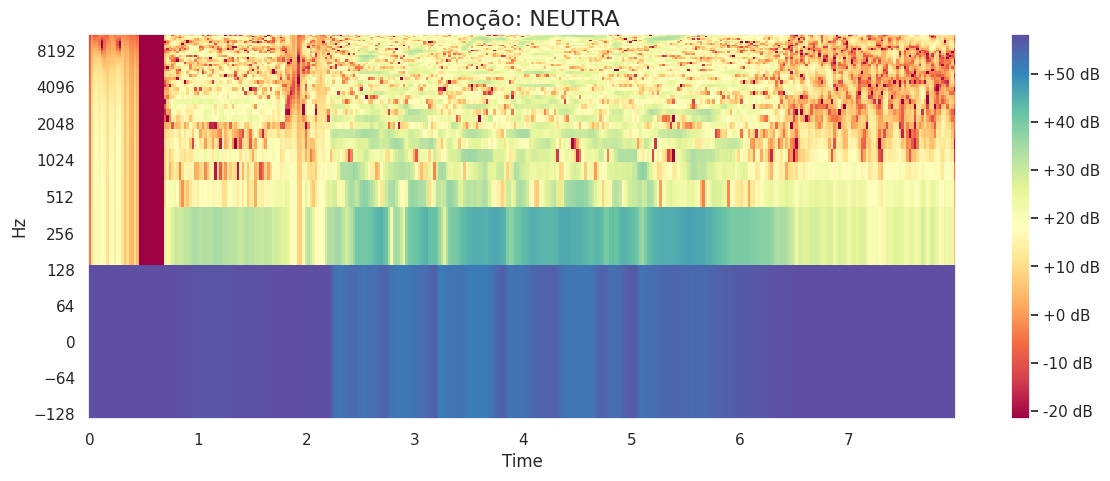

In [ ]:
predictSound(AUDIO, info = True, plot_waveform = True, plot_spectrogram = True)